# Time Series Classification and Clustering Assignment

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

### Import the Walmart stock price data set (WMT_data.csv).

In [2]:
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/WMT_data.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 69.0+ KB


,date,open,high,low,close,volume,Name
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT


In [6]:
df['date'] = pd.to_datetime(df['date'])
df.columns = ['Date', 'Open', 'High', 'Low', 'Observed', 'Volume', 'Ticker']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1259 non-null   datetime64[ns]
 1   Open      1259 non-null   float64       
 2   High      1259 non-null   float64       
 3   Low       1259 non-null   float64       
 4   Observed  1259 non-null   float64       
 5   Volume    1259 non-null   int64         
 6   Ticker    1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 69.0+ KB


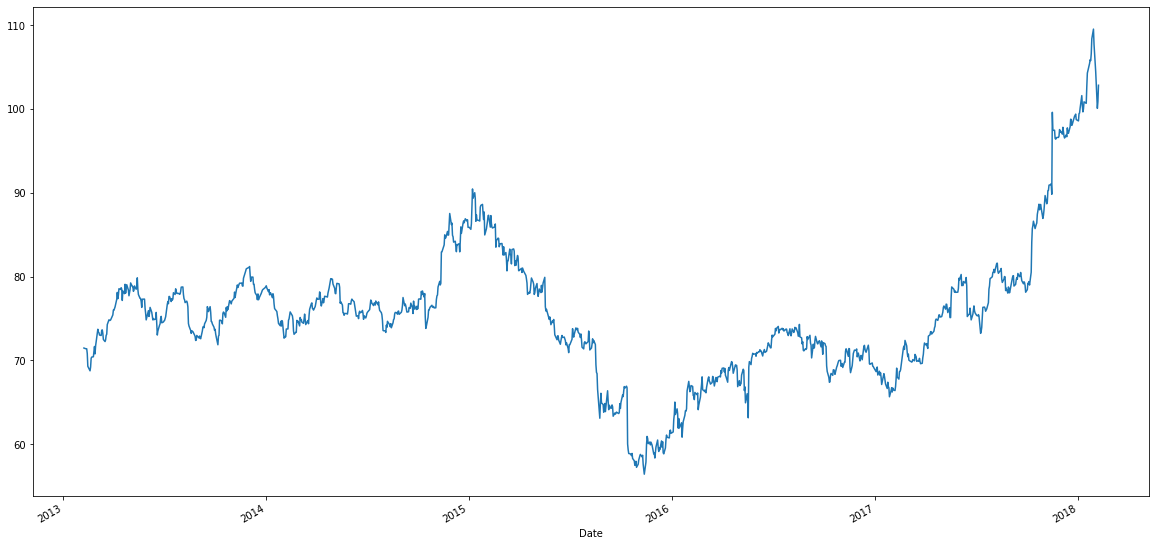

In [8]:
df.set_index('Date')['Observed'].plot(kind='line', figsize=(20,10))

### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

In [10]:
# calculate daily returns from the observed values (closing price)
df['Returns'] = df['Observed'].pct_change()
df.head()

,Date,Open,High,Low,Observed,Volume,Ticker,Returns
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT,NaN
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT,-0.001119
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT,0.000000
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT,-0.000140
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT,-0.007984


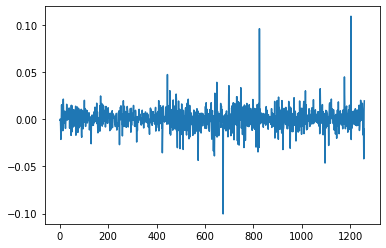

In [11]:
df['Returns'].plot()

In [12]:
# Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
df['MA_5'] = df['Observed'].rolling(5).mean()

df['Trend'] = 'None'
df.loc[(df['MA_5'] < df['Observed']), 'Trend'] = 'Negative'
df.loc[(df['MA_5'] > df['Observed']), 'Trend'] = 'Positive'
df['Change'] = df['Trend'].eq(df['Trend'].shift())
df.tail()

,Date,Open,High,Low,Observed,Volume,Ticker,Returns,MA_5,Trend,Change
1254,2018-02-01,105.96,106.56,105.18,105.52,6386836,WMT,-0.010131,107.558,Positive,True
1255,2018-02-02,105.15,106.47,104.15,104.48,9253068,WMT,-0.009856,106.776,Positive,True
1256,2018-02-05,103.40,104.61,97.09,100.09,12561594,WMT,-0.042018,104.884,Positive,True
1257,2018-02-06,97.64,101.08,97.25,100.90,16413797,WMT,0.008093,103.518,Positive,True
1258,2018-02-07,100.50,104.59,100.01,102.85,11165223,WMT,0.019326,102.768,Negative,False


In [13]:
# Create a binary column that defaults to 0 unless the criteria is met (then updates to 1)
df['Binary'] = 0
df.loc[(df['Change']==False) & (df['Trend'] != 'None'), 'Binary'] = 1

df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Observed,Volume,Ticker,Returns,MA_5,Trend,Change,Binary
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT,-0.007984,71.298,Positive,False,1
5,2013-02-15,69.54,70.00,68.130,69.30,25687156,WMT,-0.021463,70.862,Positive,True,0
6,2013-02-19,69.19,69.45,68.540,68.76,14683322,WMT,-0.007792,70.334,Positive,True,0
7,2013-02-20,68.72,69.85,68.300,69.21,11973720,WMT,0.006545,69.896,Positive,True,0
8,2013-02-21,70.00,71.47,69.720,70.26,20425983,WMT,0.015171,69.670,Negative,False,1


In [15]:
# Shift the data set so that you have 180 days of history for each record
transformed = df[['Date', 'Returns', 'Binary']]

history = 180
future = 0

shifts = [x + future for x in list(range(1, history + 1))]

for shift in shifts:
    transformed['t-' + str(shift)] = transformed['Returns'].shift(shift)

transformed.dropna(inplace=True)
transformed.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Date,Returns,Binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,...,t-141,t-142,t-143,t-144,t-145,t-146,t-147,t-148,t-149,t-150,t-151,t-152,t-153,t-154,t-155,t-156,t-157,t-158,t-159,t-160,t-161,t-162,t-163,t-164,t-165,t-166,t-167,t-168,t-169,t-170,t-171,t-172,t-173,t-174,t-175,t-176,t-177,t-178,t-179,t-180
184,2013-10-31,-0.002080,1,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,0.001217,0.006122,...,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463,-0.007984
185,2013-11-01,0.004169,1,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,0.001217,...,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463
186,2013-11-04,0.003374,0,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,...,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792
187,2013-11-05,0.001164,0,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,...,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545
188,2013-11-06,0.009558,0,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,...,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.00013

### Train a Logistic Regression classification model on the transformed data.

In [16]:
x = transformed.drop(['Date', 'Returns', 'Binary'], axis=1)
y = transformed['Binary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=False)

In [17]:
y_train.value_counts()

0    626
1    234
Name: Binary, dtype: int64

In [18]:
model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)
predictions = model.predict(x_test)

### Run a classification report and evaluate the performance of the classifier.

In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70       161
           1       0.30      0.46      0.36        54

    accuracy                           0.59       215
   macro avg       0.54      0.55      0.53       215
weighted avg       0.66      0.59      0.61       215



### Transform the data again to have 10 days of history for clustering.

In [21]:
transformed = df[['Date', 'Returns', 'Binary']]

history = 10
future = 0

shifts = [x + future for x in list(range(1, history + 1))]

for shift in shifts:
    transformed['t-' + str(shift)] = transformed['Returns'].shift(shift)

transformed.dropna(inplace=True)

x = transformed.drop(['Date', 'Returns', 'Binary'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [25]:
def kmeans(df, clusters=2):
    model = KMeans(n_clusters=clusters)
    clusters = model.fit_predict(df)
    results = df.copy()
    results['Cluster'] = clusters
    
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    
    return results, summary

In [31]:
#2 clusters
results_2, summary_2 = kmeans(x, clusters=2)
summary_2

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,661,-0.000871,0.002923,0.002055,-0.002993,-0.002002,0.003889,0.003228,-0.001402,-0.002558,-0.000627
1,1,584,0.001698,-0.002597,-0.001526,0.004206,0.003104,-0.003519,-0.002731,0.002477,0.003720,0.001508


In [32]:
#5 clusters
results_5, summary_5 = kmeans(x, clusters=5)
summary_5

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,261,0.003081,-0.005103,-0.001733,0.003114,0.009716,-0.003031,0.000035,0.001726,-0.000955,0.002370
1,1,241,0.002321,-0.003815,0.001967,0.000808,-0.001727,0.005481,0.003082,0.000966,0.003688,-0.009781
2,2,223,0.001979,0.007311,-0.006566,-0.007074,0.000933,0.003658,0.004900,-0.001893,-0.005469,0.000629
3,3,285,-0.006376,0.000473,0.004567,-0.001176,-0.000705,0.001721,-0.000537,-0.003900,0.005511,0.007107
4,4,235,0.001824,0.003838,0.002588,0.005885,-0.006966,-0.005619,-0.004906,0.005832,-0.002164,0.000168


In [33]:
#10 clusters
results_10, summary_10 = kmeans(x, clusters=10)
summary_10

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,166,0.000247,-0.007965,0.000425,0.012165,-0.001686,0.000776,0.002798,-0.002519,-0.000397,-0.000063
1,1,188,0.003493,0.001911,0.007630,-0.004491,-0.008498,0.000448,0.007640,-0.000218,-0.002950,-0.000740
2,2,42,-0.001590,0.002862,0.001218,0.004095,-0.000130,0.004490,-0.025442,-0.008696,0.002148,-0.001455
3,3,140,-0.002927,-0.002446,-0.000302,0.000400,0.002935,-0.008559,-0.000997,0.011001,-0.005946,-0.005384
4,4,127,-0.011934,-0.001731,0.001898,-0.006091,0.000086,0.007288,0.000853,-0.001956,0.000384,0.003792
5,5,89,0.005274,-0.001167,0.000067,-0.000675,-0.000162,-0.001638,-0.002798,0.002726,0.000528,0.019078
6,6,163,0.001572,-0.002143,0.002186,-0.001161,0.001869,0.002049,-0.002449,0.002443,0.012010,-0.004992
7,7,2,0.102394,-0.021893,-0.006418,0.008700,-0.010853,0.003534,-0.010005,0.000321,-0.000336,0.012692
8,8,142,-0.001315,0.014542,-0.000673,0.001204,0.000993,-0.005787,-0.000242,-0.002473,0.003394,0.000570
9,9,186,0.005199,0.001358,-0.008287,-0.000488,0.008288,0.005447,0.002367,-0.001277,-0.003709,-0.000222


### Visualize the summary of the clustering results as a heatmap.

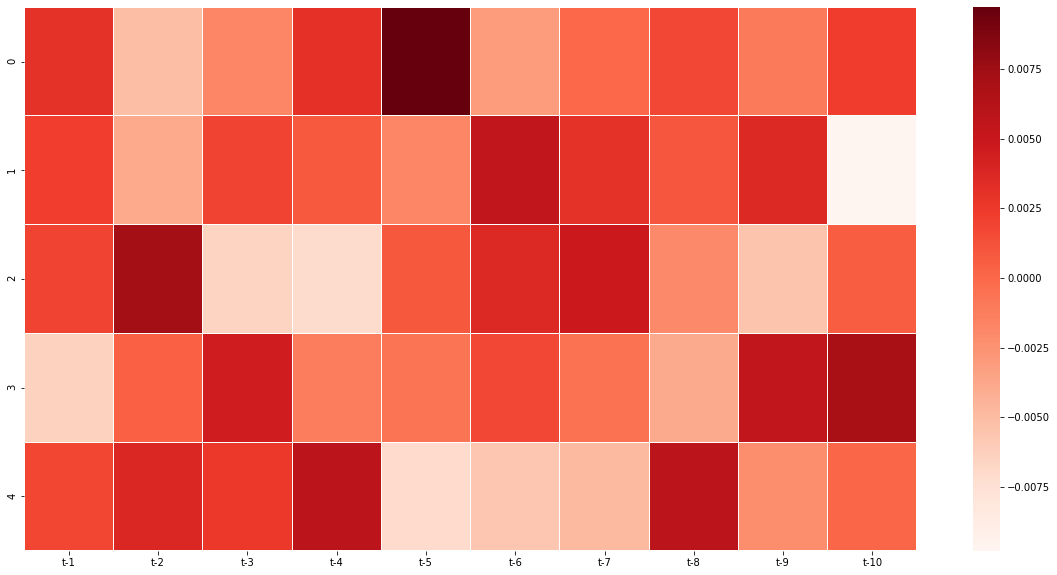

In [36]:
plt.figure(figsize=(20,10))
sns.heatmap(summary_5.drop(columns=['Cluster', 'Count']), cmap='Reds', linewidths=0.01)